In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats.stats import pearsonr  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error, median_absolute_error
import xgboost as xgb

C:\Users\hardi\Anaconda3\lib\site-packages\sklearn\grid_search.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, Sized
C:\Users\hardi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\hardi\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\

In [2]:
#loading datasets
df = pd.read_csv("trip.csv")
weather = pd.read_csv("weather.csv")
stations = pd.read_csv("station.csv")

In [3]:
df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [4]:
df.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

In [5]:
df.duration.describe()

count    6.699590e+05
mean     1.107950e+03
std      2.225544e+04
min      6.000000e+01
25%      3.440000e+02
50%      5.170000e+02
75%      7.550000e+02
max      1.727040e+07
Name: duration, dtype: float64

In [6]:
df.duration /= 60
df.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

In [7]:
#I want to remove major outliers from the data; trips longer than 6 hours. This will remove less than 0.5% of the data.
df['duration'].quantile(0.995)
df = df[df.duration <= 360]

In [8]:
df.shape

(666872, 11)

In [9]:
#Convert to datetime so that it can be manipulated more easily
df.start_date = pd.to_datetime(df.start_date, format='%m/%d/%Y %H:%M')

In [10]:
df.start_date = df.start_date.dt.floor('h')
df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,1.050000,2013-08-29 14:00:00,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,1.166667,2013-08-29 14:00:00,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,1.183333,2013-08-29 10:00:00,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,1.283333,2013-08-29 11:00:00,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,1.383333,2013-08-29 12:00:00,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [11]:
df['date'] = df.start_date.dt.date

In [12]:
df3 = df
df3.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,date
0,4576,1.050000,2013-08-29 14:00:00,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127,2013-08-29
1,4607,1.166667,2013-08-29 14:00:00,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138,2013-08-29
2,4130,1.183333,2013-08-29 10:00:00,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214,2013-08-29
3,4251,1.283333,2013-08-29 11:00:00,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060,2013-08-29
4,4299,1.383333,2013-08-29 12:00:00,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103,2013-08-29


In [13]:
#counting trips by date
dates = {}
for d in df3.start_date:
    if d not in dates:
        dates[d] = 1
    else:
        dates[d] += 1

In [15]:
#Create the data frame that will be used for training, with the dictionary we just created.
df2 = pd.DataFrame.from_dict(dates, orient = "index")
df2['date'] = df2.index
df2['trips'] = df2.ix[:,0]
train = df2.ix[:,1:3]
train.reset_index(drop = True, inplace = True)

C:\Users\hardi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\hardi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


In [19]:
#merging with stations and removing unnecessary columns
stations.rename(columns = {'id':'start_station_id'}, inplace = True)
trips_agg = pd.merge(df3, stations, on='start_station_id',how='left')
trips_agg.drop(['zip_code','name','lat','long','dock_count','installation_date'], axis=1,inplace=True)
trips_agg.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,date,city
0,4576,1.050000,2013-08-29 14:00:00,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,2013-08-29,San Francisco
1,4607,1.166667,2013-08-29 14:00:00,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,2013-08-29,San Jose
2,4130,1.183333,2013-08-29 10:00:00,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,2013-08-29,Mountain View
3,4251,1.283333,2013-08-29 11:00:00,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,2013-08-29,San Jose
4,4299,1.383333,2013-08-29 12:00:00,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,2013-08-29,San Francisco


In [20]:
trips_agg=trips_agg.groupby(['start_date','city']).size().reset_index(name='counts')

In [21]:
#All sorted now!
train = trips_agg.sort_values(by=['start_date'])
# train.groupby(pd.TimeGrouper(key='start_date', freq='4H')).sum()
# df.set_index('date')
train.reset_index(drop=True, inplace=True)
train.head()

,start_date,city,counts
0,2013-08-29 09:00:00,Mountain View,2
1,2013-08-29 09:00:00,Redwood City,1
2,2013-08-29 09:00:00,San Francisco,9
3,2013-08-29 10:00:00,Mountain View,2
4,2013-08-29 10:00:00,Palo Alto,2


In [22]:
zip_code=[]
for c in trips_agg.city:
    if c=='San Francisco':
        zip_code.append(94107)
    elif c=='San Jose':
        zip_code.append(95113)
    elif c=='Redwood City':
        zip_code.append(94063)
    elif c=='Palo Alto':
        zip_code.append(94301)
    elif c=='Mountain View':
        zip_code.append(94041)

trips_agg['zip_code']=zip_code
# len(zip_code)

In [23]:

weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [25]:
#I used this zip code for my other report as well. It is missing only a bit of data and is formatted rather well.

weather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [26]:
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y')

In [27]:
print (train.shape)
print (weather.shape)

(39573, 3)
(3665, 24)


In [28]:
weather.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

In [29]:
weather.loc[weather.events == 'rain', 'events'] = "Rain"
weather.loc[weather.events.isnull(), 'events'] = "Normal"

In [32]:
events = pd.get_dummies(weather.events)

In [33]:
weather = weather.merge(events, left_index = True, right_index = True)

In [34]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,0,4.0,Normal,286.0,94107,0,0,1,0,0
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,0,2.0,Normal,291.0,94107,0,0,1,0,0
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,0,4.0,Normal,284.0,94107,0,0,1,0,0
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,0,4.0,Normal,284.0,94107,0,0,1,0,0
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,0,6.0,Normal,277.0,94107,0,0,1,0,0


In [35]:
#max_wind and max_gust are well correlated, so we can use max_wind to help fill the null values of max_gust
print (pearsonr(weather.max_wind_Speed_mph[weather.max_gust_speed_mph >= 0], 
               weather.max_gust_speed_mph[weather.max_gust_speed_mph >= 0]))

(0.571287220922865, 2.009871572042388e-239)


In [36]:
#For each value of max_wind, find the median max_gust and use that to fill the null values.
weather.loc[weather.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] = weather.groupby('max_wind_Speed_mph').max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

In [37]:
weather.isnull().sum()

date                               0
max_temperature_f                  4
mean_temperature_f                 4
min_temperature_f                  4
max_dew_point_f                   54
mean_dew_point_f                  54
min_dew_point_f                   54
max_humidity                      54
mean_humidity                     54
min_humidity                      54
max_sea_level_pressure_inches      1
mean_sea_level_pressure_inches     1
min_sea_level_pressure_inches      1
max_visibility_miles              13
mean_visibility_miles             13
min_visibility_miles              13
max_wind_Speed_mph                 1
mean_wind_speed_mph                1
max_gust_speed_mph                13
precipitation_inches               1
cloud_cover                        1
events                             0
wind_dir_degrees                   1
zip_code                           0
Fog                                0
Fog-Rain                           0
Normal                             0
R

In [38]:
#Change this feature from a string to numeric.
#Use errors = 'coerce' because some values currently equal 'T' and we want them to become NAs.
weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors = 'coerce')

In [39]:
#Change null values to the median, of values > 0, because T, I think, means True. 
#Therefore we want to find the median amount of precipitation on days when it rained.
weather.loc[weather.precipitation_inches.isnull(), 
            'precipitation_inches'] = weather[weather.precipitation_inches.notnull()].precipitation_inches.median()

In [40]:
weather.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,0.0,4.0,Normal,286.0,94107,0,0,1,0,0
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,0.0,2.0,Normal,291.0,94107,0,0,1,0,0
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,0.0,4.0,Normal,284.0,94107,0,0,1,0,0
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,0.0,4.0,Normal,284.0,94107,0,0,1,0,0
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,0.0,6.0,Normal,277.0,94107,0,0,1,0,0


In [41]:
trips_agg['date']=trips_agg.start_date.dt.date
trips_agg['date']=pd.to_datetime(trips_agg['date'])
trips_agg.dtypes

start_date    datetime64[ns]
city                  object
counts                 int64
zip_code               int64
date          datetime64[ns]
dtype: object

In [42]:
train = pd.merge(trips_agg, weather, on=['date','zip_code'])
train.head()

,start_date,city,counts,zip_code,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm
0,2013-08-29 09:00:00,Mountain View,2,94041,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,16.0,0.0,4.0,Normal,355.0,0,0,1,0,0
1,2013-08-29 10:00:00,Mountain View,2,94041,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,16.0,0.0,4.0,Normal,355.0,0,0,1,0,0
2,2013-08-29 14:00:00,Mountain View,1,94041,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,16.0,0.0,4.0,Normal,355.0,0,0,1,0,0
3,2013-08-29 16:00:00,Mountain View,1,94041,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,16.0,0.0,4.0,Normal,355.0,0,0,1,0,0
4,2013-08-29 17:00:00,Mountain View,1,94041,2013-08-29,80.0,70.0,64.0,65.0,61.0,...,16.0,0.0,4.0,Normal,355.0,0,0,1,0,0


In [43]:

train.drop(['city','zip_code'],1, inplace= True)

In [44]:
stations.head()

,start_station_id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [45]:
#Good, each stations is only listed once
print (len(stations.name.unique()))
print (stations.shape)

70
(70, 7)


In [46]:
stations.installation_date = pd.to_datetime(stations.installation_date, format = "%m/%d/%Y").dt.date

In [47]:
#The min date is before any in the train data frame, therefore stations were installed before the first trips (good).
#The max date is before the end of the train data frame, therefore the service has not been adding new stations recently.
print (stations.installation_date.min())
print (stations.installation_date.max())

2013-08-05
2014-04-09


In [48]:
#For each day in train.date, find the number of docks (parking spots for individual bikes) that were installed 
#on or before that day.
total_docks = []
for day in pd.to_datetime(train.date, format = "%m/%d/%Y").dt.date:
    total_docks.append(sum(stations[stations.installation_date <= day].dock_count))

In [49]:
train['total_docks'] = total_docks

In [50]:
#Find all of the holidays during our time span
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.date.min(), end=train.date.max())

In [51]:
#Find all of the business days in our time span
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=train.date.min(), end=train.date.max(), freq=us_bd)

In [52]:
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date

In [53]:
#A 'business_day' or 'holiday' is a date within either of the respected lists.
train['business_day'] = train.date.isin(business_days)
train['holiday'] = train.date.isin(holidays)

In [54]:
train.head()

,start_date,counts,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,events,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain,Rain-Thunderstorm,total_docks,business_day,holiday
0,2013-08-29 09:00:00,2,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,Normal,355.0,0,0,1,0,0,1150,True,False
1,2013-08-29 10:00:00,2,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,Normal,355.0,0,0,1,0,0,1150,True,False
2,2013-08-29 14:00:00,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,Normal,355.0,0,0,1,0,0,1150,True,False
3,2013-08-29 16:00:00,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,Normal,355.0,0,0,1,0,0,1150,True,False
4,2013-08-29 17:00:00,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,Normal,355.0,0,0,1,0,0,1150,True,False


In [55]:
#Convert True to 1 and False to 0
train.business_day = train.business_day.map(lambda x: 1 if x == True else 0)
train.holiday = train.holiday.map(lambda x: 1 if x == True else 0)

In [56]:
#Convert date to the important features, year, month, weekday (0 = Monday, 1 = Tuesday...)
#We don't need day because what it represents changes every year.
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['weekday'] = pd.to_datetime(train['date']).dt.weekday
train['day'] = pd.to_datetime(train['date']).dt.day
train['hour'] = pd.to_datetime(train['start_date']).dt.hour

In [57]:
train.head()

,start_date,counts,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,...,Rain,Rain-Thunderstorm,total_docks,business_day,holiday,year,month,weekday,day,hour
0,2013-08-29 09:00:00,2,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,0,0,1150,1,0,2013,8,3,29,9
1,2013-08-29 10:00:00,2,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,0,0,1150,1,0,2013,8,3,29,10
2,2013-08-29 14:00:00,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,0,0,1150,1,0,2013,8,3,29,14
3,2013-08-29 16:00:00,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,0,0,1150,1,0,2013,8,3,29,16
4,2013-08-29 17:00:00,1,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,...,0,0,1150,1,0,2013,8,3,29,17


In [58]:
labels = train.counts
train.columns

Index(['start_date', 'counts', 'date', 'max_temperature_f',
       'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
       'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_sea_level_pressure_inches',
       'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
       'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles',
       'max_wind_Speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
       'precipitation_inches', 'cloud_cover', 'events', 'wind_dir_degrees',
       'Fog', 'Fog-Rain', 'Normal', 'Rain', 'Rain-Thunderstorm', 'total_docks',
       'business_day', 'holiday', 'year', 'month', 'weekday', 'day', 'hour'],
      dtype='object')

max_temperature_f                -0.080564
mean_temperature_f               -0.027632
min_temperature_f                 0.027777
max_dew_point_f                  -0.001226
mean_dew_point_f                  0.037517
min_dew_point_f                   0.060041
max_humidity                      0.019395
mean_humidity                     0.080214
min_humidity                      0.124066
max_sea_level_pressure_inches    -0.016190
mean_sea_level_pressure_inches   -0.014635
min_sea_level_pressure_inches    -0.005907
max_visibility_miles             -0.093919
mean_visibility_miles            -0.056957
min_visibility_miles             -0.038823
max_wind_Speed_mph                0.102829
mean_wind_speed_mph               0.211690
max_gust_speed_mph                0.100757
precipitation_inches             -0.013064
cloud_cover                       0.149516
wind_dir_degrees                 -0.023448
Fog                               0.070040
Fog-Rain                          0.024037
Normal     

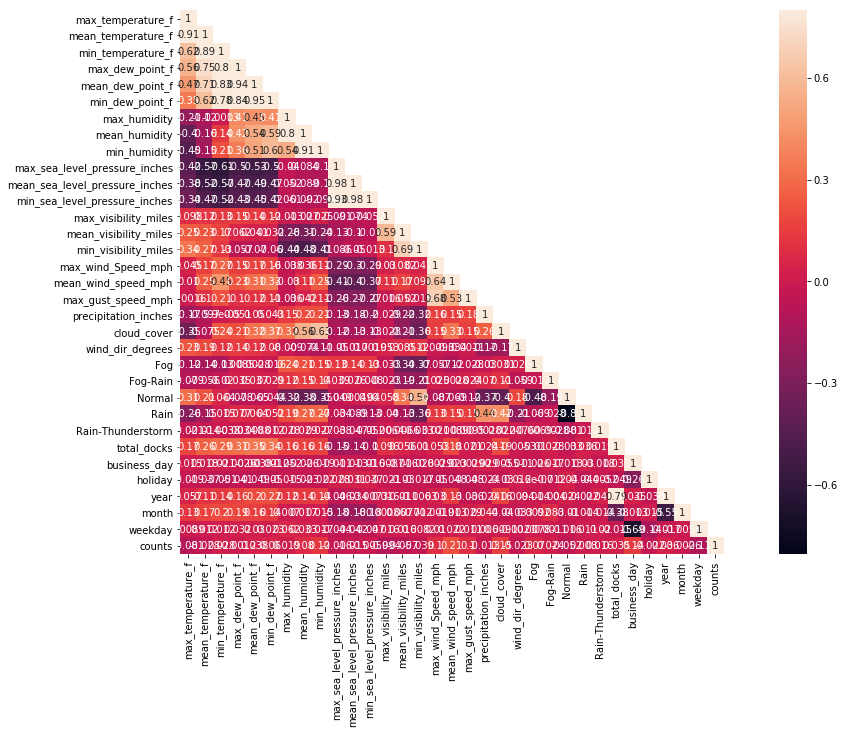

In [59]:
corrMatt = train[[
        'max_temperature_f',
       'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
       'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_sea_level_pressure_inches',
       'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
       'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles',
       'max_wind_Speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
       'precipitation_inches', 'cloud_cover', 'events', 'wind_dir_degrees',
       'Fog', 'Fog-Rain', 'Normal', 'Rain', 'Rain-Thunderstorm', 'total_docks',
       'business_day', 'holiday', 'year', 'month', 'weekday','counts']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
corrMatt['counts']